<a href="https://colab.research.google.com/github/GiovanniBorrelli/StockPredict/blob/main/StockPredict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [133]:
# INSTALLA LIBRERIE
!pip install yfinance pandas scikit-learn matplotlib ta --quiet
!pip install yfinance ta xgboost scikit-learn matplotlib --quiet

# IMPORTA MODULI
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import ta
import yfinance as yf
import pandas as pd
import numpy as np
import ta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt

In [194]:
ticker = "rklb"
start_date = "2020-01-01"
df = yf.download(ticker, start=start_date, auto_adjust=True)
print("Massima data disponibile nel dataset:", df.index[-1])

Massima data disponibile nel dataset: 2025-07-14 00:00:00


[*********************100%***********************]  1 of 1 completed


Ticker: nflx
Accuracy del modello (selezione feature): 0.47
Confusion Matrix:
[[ 81  78]
 [106  80]]

Previsione per il giorno dopo 2025-07-14 :
Segnale di acquisto
Probabilità (Vendita, Acquisto): [0.4 0.6]

Media variazione % dopo segnali compra:
1 giorni: 0.0161 (1.61%)
5 giorni: 0.0205 (2.05%)
7 giorni: 0.0266 (2.66%)
30 giorni: 0.0634 (6.34%)


[*********************100%***********************]  1 of 1 completed



Ultimo giorno disponibile: 2025-07-14

Affidabilità guadagno dopo 7 giorni: 60.13%
Affidabilità guadagno dopo 30 giorni: 76.58%
Guadagno medio positivo dopo 7 giorni: 5.95%
Guadagno medio positivo dopo 30 giorni: 13.03%

Numero di segnali di acquisto nel test set: 158
📉 Guadagno medio netto dopo 7 giorni: 2.31%
📉 Guadagno medio netto dopo 30 giorni: 10.99%
📉 Perdita media quando sbaglia (7 giorni): -3.55%
📉 Perdita media quando sbaglia (30 giorni): -5.44%
Mediana dei guadagni positivi (30 giorni): 12.55%

Consiglio per il giorno 2025-07-15: ti consiglio di acquistare con una probabilità del 60%.


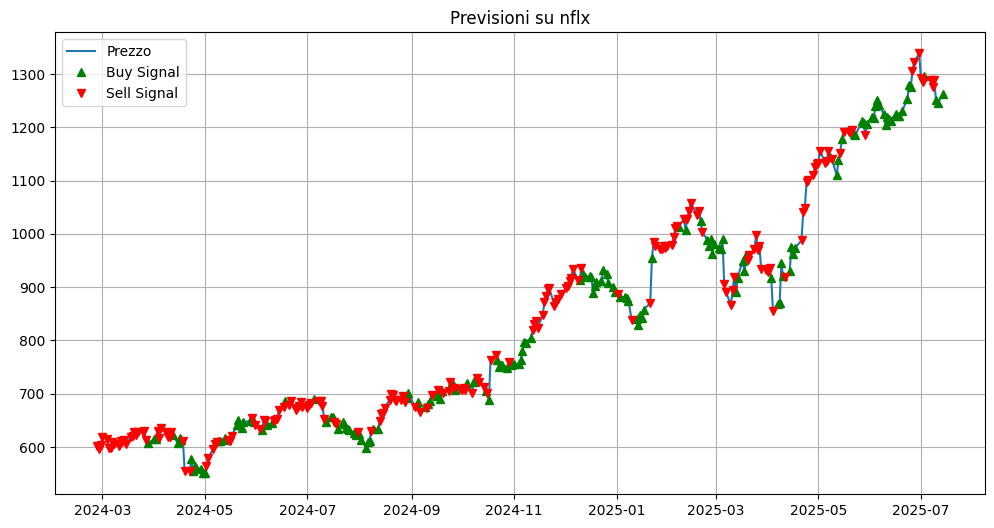

In [284]:
# 1. Scarica i dati
ticker = "nflx"
start_date = "2020-01-01"
df = yf.download(ticker, start=start_date, auto_adjust=True)

# 2. Prepara la Series per gli indicatori
close_prices_series = pd.Series(df['Close'].values.flatten(), index=df.index)

# 3. Calcola indicatori tecnici
df['rsi'] = ta.momentum.RSIIndicator(close=close_prices_series).rsi()
df['sma'] = ta.trend.SMAIndicator(close=close_prices_series, window=10).sma_indicator()
df['ema'] = ta.trend.EMAIndicator(close=close_prices_series, window=10).ema_indicator()
df['macd'] = ta.trend.MACD(close=close_prices_series).macd_diff()
bb = ta.volatility.BollingerBands(close=close_prices_series, window=20, window_dev=2)
df['bb_percent'] = bb.bollinger_pband()
stoch = ta.momentum.StochasticOscillator(high=df['High'], low=df['Low'], close=close_prices_series, window=14)
df['stoch_k'] = ta.momentum.StochasticOscillator(high=high_prices_series, low=low_prices_series, close=close_prices_series, window=14).stoch()

# 4. Crea target
df['target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)
df = df.dropna()

# 5. Feature selection automatica
all_features = ['rsi', 'sma', 'ema', 'macd', 'bb_percent', 'stoch_k']
X_all = df[all_features]
y = df['target']

# 6. Split temporale
X_train, X_test, y_train, y_test = train_test_split(X_all, y, shuffle=False, test_size=0.3)

# 7. Prima RandomForest per stimare importanza feature
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 8. Seleziona feature migliori
selector = SelectFromModel(model, threshold="median", prefit=True)
X_train_sel = selector.transform(X_train)
X_test_sel = selector.transform(X_test)

# 9. Allena modello finale
model_sel = RandomForestClassifier(n_estimators=100, random_state=42)
model_sel.fit(X_train_sel, y_train)

# 10. Valutazione
y_pred = model_sel.predict(X_test_sel)
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"Ticker: {ticker}")
print(f"Accuracy del modello (selezione feature): {acc:.2f}")
print("Confusion Matrix:")
print(cm)

# 11. Previsione sul giorno successivo
X_today = df[all_features].iloc[[-1]]
X_today_sel = selector.transform(X_today)
pred = model_sel.predict(X_today_sel)[0]
prob = model_sel.predict_proba(X_today_sel)[0]

print(f"\nPrevisione per il giorno dopo {df.index[-1].date()} :")
print("Segnale di acquisto" if pred == 1 else "Segnale di vendita")
print(f"Probabilità (Vendita, Acquisto): {prob}")

# 12. Variazioni % dopo segnali di acquisto
signals_buy_dates = y_test[y_test == 1].index
variations = {1: [], 5: [], 7: [], 30: []}
for d in signals_buy_dates:
    for days_ahead in variations.keys():
        future_date = d + pd.Timedelta(days=days_ahead)
        if future_date in df.index:
            price_then = df.loc[future_date, 'Close']
            price_now = df.loc[d, 'Close']
            variation = (price_then - price_now) / price_now
            variations[days_ahead].append(variation)

print("\nMedia variazione % dopo segnali compra:")
for days_ahead, vals in variations.items():
    if vals:
        avg_var = np.mean(vals)
        print(f"{days_ahead} giorni: {avg_var:.4f} ({avg_var*100:.2f}%)")
    else:
        print(f"{days_ahead} giorni: nessun dato disponibile")

# Scarica i dati senza specificare end_date per avere dati aggiornati
df = yf.download(ticker, start=start_date, auto_adjust=True)

# Imposta end_date come l'ultimo giorno disponibile nel dataframe
end_date = df.index[-1].date()
print(f"\nUltimo giorno disponibile: {end_date}")

close_prices_series = pd.Series(df['Close'].values.flatten(), index=df.index)

# Calcola variazioni percentuali a 7 e 30 giorni
variation_7d = (close_prices_series.shift(-7) - close_prices_series) / close_prices_series
variation_30d = (close_prices_series.shift(-30) - close_prices_series) / close_prices_series

# Supponendo che y_pred sia un numpy array con la stessa lunghezza di X_test
y_pred_series = pd.Series(y_pred, index=X_test.index)

# Ora fai l’intersezione degli indici
common_index = X_test.index.intersection(variation_7d.index).intersection(variation_30d.index)

# Filtro tutte le serie per avere gli stessi indici
variation_7d_test = variation_7d.loc[common_index]
variation_30d_test = variation_30d.loc[common_index]
y_pred_filtered = y_pred_series.loc[common_index]

buy_signals = y_pred_filtered == 1


# Calcola le metriche
accuracy_7d = (variation_7d_test.loc[buy_signals] > 0).mean()
accuracy_30d = (variation_30d_test.loc[buy_signals] > 0).mean()
avg_gain_7d = variation_7d_test.loc[buy_signals][variation_7d_test.loc[buy_signals] > 0].mean()
avg_gain_30d = variation_30d_test.loc[buy_signals][variation_30d_test.loc[buy_signals] > 0].mean()
avg_total_return_7d = variation_7d_test.loc[buy_signals].mean()
avg_total_return_30d = variation_30d_test.loc[buy_signals].mean()
avg_loss_7d = variation_7d_test.loc[buy_signals][variation_7d_test.loc[buy_signals] < 0].mean()
avg_loss_30d = variation_30d_test.loc[buy_signals][variation_30d_test.loc[buy_signals] < 0].mean()
median_gain_30d = variation_30d_test.loc[buy_signals][variation_30d_test.loc[buy_signals] > 0].median()

# Stampa risultati
print(f"\nAffidabilità guadagno dopo 7 giorni: {accuracy_7d:.2%}")
print(f"Affidabilità guadagno dopo 30 giorni: {accuracy_30d:.2%}")
print(f"Guadagno medio positivo dopo 7 giorni: {avg_gain_7d:.2%}")
print(f"Guadagno medio positivo dopo 30 giorni: {avg_gain_30d:.2%}")
print(f"\nNumero di segnali di acquisto nel test set: {buy_signals.sum()}")
print(f"📉 Guadagno medio netto dopo 7 giorni: {avg_total_return_7d:.2%}")
print(f"📉 Guadagno medio netto dopo 30 giorni: {avg_total_return_30d:.2%}")
print(f"📉 Perdita media quando sbaglia (7 giorni): {avg_loss_7d:.2%}")
print(f"📉 Perdita media quando sbaglia (30 giorni): {avg_loss_30d:.2%}")
print(f"Mediana dei guadagni positivi (30 giorni): {median_gain_30d:.2%}")

next_day = df.index[-1] + pd.Timedelta(days=1)
signal = "acquistare" if pred == 1 else "vendere"
probability = prob[1] if pred == 1 else prob[0]

print(f"\nConsiglio per il giorno {next_day.date()}: ti consiglio di {signal} con una probabilità del {probability:.0%}.")

# 13. Grafico segnali
df_test = df.iloc[-len(y_test):].copy()
df_test['Prediction'] = y_pred

plt.figure(figsize=(12,6))
plt.plot(df_test.index, df_test['Close'], label='Prezzo')
plt.plot(df_test.index[df_test['Prediction'] == 1], df_test['Close'][df_test['Prediction'] == 1], '^', color='green', label='Buy Signal')
plt.plot(df_test.index[df_test['Prediction'] == 0], df_test['Close'][df_test['Prediction'] == 0], 'v', color='red', label='Sell Signal')
plt.title(f"Previsioni su {ticker}")
plt.legend()
plt.grid()
plt.show()


In [282]:
import yfinance as yf
import pandas as pd
import numpy as np
import ta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

tickers = ["Rtx", "gs", "t", "ebay", "spot", "sap", "NFLX", "rblx", "pltr"]
start_date = "2020-01-01"

# Per classifiche finali
results = {}
final_probabilities = {}
gain_7d = {}
gain_30d = {}
buy_signals_count = {}

def run_model(ticker):
    print(f"\n\n--- Analisi per {ticker} ---")

    df = yf.download(ticker, start=start_date, auto_adjust=True)
    if df.empty:
        print("Nessun dato disponibile")
        return None

    close_prices_series = pd.Series(df['Close'].values.flatten(), index=df.index)

    df['rsi'] = ta.momentum.RSIIndicator(close=close_prices_series).rsi()
    df['sma'] = ta.trend.SMAIndicator(close=close_prices_series, window=10).sma_indicator()
    df['ema'] = ta.trend.EMAIndicator(close=close_prices_series, window=10).ema_indicator()
    df['macd'] = ta.trend.MACD(close=close_prices_series).macd_diff()
    bb = ta.volatility.BollingerBands(close=close_prices_series, window=20, window_dev=2)
    df['bb_percent'] = bb.bollinger_pband()
    stoch = ta.momentum.StochasticOscillator(high=df['High'], low=df['Low'], close=close_prices_series, window=14)
    df['stoch_k'] = ta.momentum.StochasticOscillator(high=high_prices_series, low=low_prices_series, close=close_prices_series, window=14).stoch()

    df['target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)
    df = df.dropna()

    all_features = ['rsi', 'sma', 'ema', 'macd', 'bb_percent', 'stoch_k']
    X_all = df[all_features]
    y = df['target']

    X_train, X_test, y_train, y_test = train_test_split(X_all, y, shuffle=False, test_size=0.3)

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    selector = SelectFromModel(model, threshold="median", prefit=True)
    X_train_sel = selector.transform(X_train)
    X_test_sel = selector.transform(X_test)

    model_sel = RandomForestClassifier(n_estimators=100, random_state=42)
    model_sel.fit(X_train_sel, y_train)

    y_pred = model_sel.predict(X_test_sel)
    y_pred_series = pd.Series(y_pred, index=X_test.index)

    variation_7d = (close_prices_series.shift(-7) - close_prices_series) / close_prices_series
    variation_30d = (close_prices_series.shift(-30) - close_prices_series) / close_prices_series

    common_index_7d = X_test.index.intersection(variation_7d.index)
    common_index_30d = X_test.index.intersection(variation_30d.index)

    variation_7d_test = variation_7d.loc[common_index_7d]
    variation_30d_test = variation_30d.loc[common_index_30d]

    y_pred_7d = y_pred_series.loc[common_index_7d]
    y_pred_30d = y_pred_series.loc[common_index_30d]

    buy_signals_7d = y_pred_7d == 1
    buy_signals_30d = y_pred_30d == 1

    accuracy_7d = (variation_7d_test.loc[buy_signals_7d] > 0).mean() if buy_signals_7d.sum() > 0 else np.nan
    accuracy_30d = (variation_30d_test.loc[buy_signals_30d] > 0).mean() if buy_signals_30d.sum() > 0 else np.nan

    print(f"Affidabilità guadagno dopo 7 giorni per {ticker}: {accuracy_7d:.2%}" if not np.isnan(accuracy_7d) else "Nessun segnale d'acquisto a 7 giorni")
    print(f"Affidabilità guadagno dopo 30 giorni per {ticker}: {accuracy_30d:.2%}" if not np.isnan(accuracy_30d) else "Nessun segnale d'acquisto a 30 giorni")

    # Guadagno medio reale osservato
    gain_7 = variation_7d_test.loc[buy_signals_7d].mean() if buy_signals_7d.sum() > 0 else np.nan
    gain_30 = variation_30d_test.loc[buy_signals_30d].mean() if buy_signals_30d.sum() > 0 else np.nan
    count_signals = buy_signals_30d.sum()

    # Previsione attuale
    X_today = df[all_features].iloc[[-1]]
    X_today_sel = selector.transform(X_today)
    pred = model_sel.predict(X_today_sel)[0]
    prob = model_sel.predict_proba(X_today_sel)[0]

    next_day = df.index[-1] + pd.Timedelta(days=1)
    signal = "acquistare" if pred == 1 else "vendere"
    probability = prob[1] if pred == 1 else prob[0]
    print(f"Consiglio per il giorno {next_day.date()}: {signal} con probabilità {probability:.0%}")

    # Salva risultati
    results[ticker] = {"7d_acc": accuracy_7d, "30d_acc": accuracy_30d}
    final_probabilities[ticker] = probability if pred == 1 else 1 - probability
    gain_7d[ticker] = gain_7
    gain_30d[ticker] = gain_30
    buy_signals_count[ticker] = count_signals

# Esegui per tutti i ticker
for t in tickers:
    run_model(t)

# Classifiche
print("\n\n=== CLASSIFICHE FINALI ===")

print("\n--- Top Affidabilità a 7 giorni ---")
sorted_acc_7d = sorted(results.items(), key=lambda x: x[1]['7d_acc'] if not pd.isna(x[1]['7d_acc']) else -1, reverse=True)
for i, (t, r) in enumerate(sorted_acc_7d, start=1):
    print(f"{i}. {t}: {r['7d_acc']:.2%}" if not pd.isna(r['7d_acc']) else f"{i}. {t}: dati insufficienti")

print("\n--- Top Affidabilità a 30 giorni ---")
sorted_acc_30d = sorted(results.items(), key=lambda x: x[1]['30d_acc'] if not pd.isna(x[1]['30d_acc']) else -1, reverse=True)
for i, (t, r) in enumerate(sorted_acc_30d, start=1):
    print(f"{i}. {t}: {r['30d_acc']:.2%}" if not pd.isna(r['30d_acc']) else f"{i}. {t}: dati insufficienti")

print("\n--- Top Guadagno Medio a 7 giorni ---")
sorted_gain_7d = sorted(gain_7d.items(), key=lambda x: x[1] if not pd.isna(x[1]) else -999, reverse=True)
for i, (t, g) in enumerate(sorted_gain_7d, start=1):
    print(f"{i}. {t}: {g:.2%}" if not pd.isna(g) else f"{i}. {t}: dati insufficienti")

print("\n--- Top Guadagno Medio a 30 giorni ---")
sorted_gain_30d = sorted(gain_30d.items(), key=lambda x: x[1] if not pd.isna(x[1]) else -999, reverse=True)
for i, (t, g) in enumerate(sorted_gain_30d, start=1):
    print(f"{i}. {t}: {g:.2%}" if not pd.isna(g) else f"{i}. {t}: dati insufficienti")

print("\n--- Classifica Consigli di Acquisto (probabilità odierna più alta) ---")
sorted_prob = sorted(final_probabilities.items(), key=lambda x: x[1], reverse=True)
for i, (t, p) in enumerate(sorted_prob, start=1):
    print(f"{i}. {t}: {p:.0%}")

print("\n--- Numero di Segnali Osservati ---")
sorted_signals = sorted(buy_signals_count.items(), key=lambda x: x[1], reverse=True)
for i, (t, count) in enumerate(sorted_signals, start=1):
    print(f"{i}. {t}: {count} segnali")




--- Analisi per Rtx ---


[*********************100%***********************]  1 of 1 completed


Affidabilità guadagno dopo 7 giorni per Rtx: 100.00%
Affidabilità guadagno dopo 30 giorni per Rtx: 100.00%
Consiglio per il giorno 2025-07-15: vendere con probabilità 79%


--- Analisi per gs ---


[*********************100%***********************]  1 of 1 completed


Affidabilità guadagno dopo 7 giorni per gs: 58.06%
Affidabilità guadagno dopo 30 giorni per gs: 87.10%
Consiglio per il giorno 2025-07-15: vendere con probabilità 77%


--- Analisi per t ---


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Affidabilità guadagno dopo 7 giorni per t: 73.63%
Affidabilità guadagno dopo 30 giorni per t: 84.62%
Consiglio per il giorno 2025-07-15: acquistare con probabilità 54%


--- Analisi per ebay ---



[*********************100%***********************]  1 of 1 completed

Affidabilità guadagno dopo 7 giorni per ebay: 64.34%
Affidabilità guadagno dopo 30 giorni per ebay: 81.12%
Consiglio per il giorno 2025-07-15: vendere con probabilità 53%


--- Analisi per spot ---


Affidabilità guadagno dopo 7 giorni per spot: 65.00%
Affidabilità guadagno dopo 30 giorni per spot: 80.00%
Consiglio per il giorno 2025-07-15: vendere con probabilità 58%


--- Analisi per sap ---


[*********************100%***********************]  1 of 1 completed


Affidabilità guadagno dopo 7 giorni per sap: 56.74%
Affidabilità guadagno dopo 30 giorni per sap: 77.53%
Consiglio per il giorno 2025-07-15: vendere con probabilità 56%


--- Analisi per NFLX ---


[*********************100%***********************]  1 of 1 completed


Affidabilità guadagno dopo 7 giorni per NFLX: 60.13%
Affidabilità guadagno dopo 30 giorni per NFLX: 76.58%
Consiglio per il giorno 2025-07-15: acquistare con probabilità 60%


--- Analisi per rblx ---


[*********************100%***********************]  1 of 1 completed


Affidabilità guadagno dopo 7 giorni per rblx: 63.64%
Affidabilità guadagno dopo 30 giorni per rblx: 58.59%
Consiglio per il giorno 2025-07-15: acquistare con probabilità 73%


--- Analisi per pltr ---


[*********************100%***********************]  1 of 1 completed


Affidabilità guadagno dopo 7 giorni per pltr: 64.04%
Affidabilità guadagno dopo 30 giorni per pltr: 73.03%
Consiglio per il giorno 2025-07-15: vendere con probabilità 78%


=== CLASSIFICHE FINALI ===

--- Top Affidabilità a 7 giorni ---
1. Rtx: 100.00%
2. t: 73.63%
3. spot: 65.00%
4. ebay: 64.34%
5. pltr: 64.04%
6. rblx: 63.64%
7. NFLX: 60.13%
8. gs: 58.06%
9. sap: 56.74%

--- Top Affidabilità a 30 giorni ---
1. Rtx: 100.00%
2. gs: 87.10%
3. t: 84.62%
4. ebay: 81.12%
5. spot: 80.00%
6. sap: 77.53%
7. NFLX: 76.58%
8. pltr: 73.03%
9. rblx: 58.59%

--- Top Guadagno Medio a 7 giorni ---
1. pltr: 4.66%
2. Rtx: 2.69%
3. spot: 2.49%
4. NFLX: 2.31%
5. rblx: 2.10%
6. gs: 2.03%
7. t: 1.72%
8. ebay: 1.41%
9. sap: 0.85%

--- Top Guadagno Medio a 30 giorni ---
1. pltr: 14.71%
2. Rtx: 11.44%
3. NFLX: 10.99%
4. spot: 10.44%
5. rblx: 8.74%
6. t: 6.36%
7. gs: 5.53%
8. sap: 4.95%
9. ebay: 4.68%

--- Classifica Consigli di Acquisto (probabilità odierna più alta) ---
1. rblx: 73%
2. NFLX: 60%
3. t: 54%
4.

In [ ]:
tickers = ["AAPL","MSFT","AMZN","GOOGL","META","NFLX","TSLA","NVDA","RBLX","RKLB","JPM","BAC","WFC","C","GS","MS","V","MA","PYPL","SQ","DIS","CMCSA","T","VZ","TMUS","SBUX","MCD","NKE","KO","PEP","HD","LOW","COST","WMT","CVS","UNH","JNJ","PFE","MRK","ABBV","BMY","TXN","QCOM","INTC","AMD","IBM","ORCL","CRM","NOW","ZM","DOCU","TWLO","WORK","OKTA","SPLK","SNOW","UBER","LYFT","ZS","BA","LMT","NOC","RTX","GD","HON","CAT","DE","UPS","FDX","GM","F","TM","HMC","NIO","LI","XPEV","PLTR","SPOT","ADBE","ACN","IT","SAP","VEEV","ETSY","SHOP","EBAY","BIDU","TCEHY","NVAX","MRNA","BNTX","REGN","GILD","ALXN","BIIB","CRSP","VRTX","ZM"]

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import ta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

tickers = ["AAPL","MSFT","AMZN","GOOGL","META","NFLX","TSLA","NVDA","RBLX","RKLB","JPM","BAC","WFC","C","GS","MS","V","MA","PYPL","SQ","DIS","CMCSA","T","VZ","TMUS","SBUX","MCD","NKE","KO","PEP","HD","LOW","COST","WMT","CVS","UNH","JNJ","PFE","MRK","ABBV","BMY","TXN","QCOM","INTC","AMD","IBM","ORCL","CRM","NOW","ZM","DOCU","TWLO","WORK","OKTA","SPLK","SNOW","UBER","LYFT","ZS","BA","LMT","NOC","RTX","GD","HON","CAT","DE","UPS","FDX","GM","F","TM","HMC","NIO","LI","XPEV","PLTR","SPOT","ADBE","ACN","IT","SAP","VEEV","ETSY","SHOP","EBAY","BIDU","TCEHY","NVAX","MRNA","BNTX","REGN","GILD","ALXN","BIIB","CRSP","VRTX","ZM"]
start_date = "2020-01-01"

# Per classifiche finali
results = {}
final_probabilities = {}
gain_7d = {}
gain_30d = {}
buy_signals_count = {}

def run_model(ticker):
    print(f"\n\n--- Analisi per {ticker} ---")

    df = yf.download(ticker, start=start_date, auto_adjust=True)
    if df.empty:
        print("Nessun dato disponibile")
        return None

    close_prices_series = pd.Series(df['Close'].values.flatten(), index=df.index)

    df['rsi'] = ta.momentum.RSIIndicator(close=close_prices_series).rsi()
    df['sma'] = ta.trend.SMAIndicator(close=close_prices_series, window=10).sma_indicator()
    df['ema'] = ta.trend.EMAIndicator(close=close_prices_series, window=10).ema_indicator()
    df['macd'] = ta.trend.MACD(close=close_prices_series).macd_diff()
    bb = ta.volatility.BollingerBands(close=close_prices_series, window=20, window_dev=2)
    df['bb_percent'] = bb.bollinger_pband()
    stoch = ta.momentum.StochasticOscillator(high=df['High'], low=df['Low'], close=close_prices_series, window=14)
    df['stoch_k'] = ta.momentum.StochasticOscillator(high=high_prices_series, low=low_prices_series, close=close_prices_series, window=14).stoch()

    df['target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)
    df = df.dropna()

    all_features = ['rsi', 'sma', 'ema', 'macd', 'bb_percent', 'stoch_k']
    X_all = df[all_features]
    y = df['target']

    X_train, X_test, y_train, y_test = train_test_split(X_all, y, shuffle=False, test_size=0.3)

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    selector = SelectFromModel(model, threshold="median", prefit=True)
    X_train_sel = selector.transform(X_train)
    X_test_sel = selector.transform(X_test)

    model_sel = RandomForestClassifier(n_estimators=100, random_state=42)
    model_sel.fit(X_train_sel, y_train)

    y_pred = model_sel.predict(X_test_sel)
    y_pred_series = pd.Series(y_pred, index=X_test.index)

    variation_7d = (close_prices_series.shift(-7) - close_prices_series) / close_prices_series
    variation_30d = (close_prices_series.shift(-30) - close_prices_series) / close_prices_series

    common_index_7d = X_test.index.intersection(variation_7d.index)
    common_index_30d = X_test.index.intersection(variation_30d.index)

    variation_7d_test = variation_7d.loc[common_index_7d]
    variation_30d_test = variation_30d.loc[common_index_30d]

    y_pred_7d = y_pred_series.loc[common_index_7d]
    y_pred_30d = y_pred_series.loc[common_index_30d]

    buy_signals_7d = y_pred_7d == 1
    buy_signals_30d = y_pred_30d == 1

    accuracy_7d = (variation_7d_test.loc[buy_signals_7d] > 0).mean() if buy_signals_7d.sum() > 0 else np.nan
    accuracy_30d = (variation_30d_test.loc[buy_signals_30d] > 0).mean() if buy_signals_30d.sum() > 0 else np.nan

    print(f"Affidabilità guadagno dopo 7 giorni per {ticker}: {accuracy_7d:.2%}" if not np.isnan(accuracy_7d) else "Nessun segnale d'acquisto a 7 giorni")
    print(f"Affidabilità guadagno dopo 30 giorni per {ticker}: {accuracy_30d:.2%}" if not np.isnan(accuracy_30d) else "Nessun segnale d'acquisto a 30 giorni")

    # Guadagno medio reale osservato
    gain_7 = variation_7d_test.loc[buy_signals_7d].mean() if buy_signals_7d.sum() > 0 else np.nan
    gain_30 = variation_30d_test.loc[buy_signals_30d].mean() if buy_signals_30d.sum() > 0 else np.nan
    count_signals = buy_signals_30d.sum()

    # Previsione attuale
    X_today = df[all_features].iloc[[-1]]
    X_today_sel = selector.transform(X_today)
    pred = model_sel.predict(X_today_sel)[0]
    prob = model_sel.predict_proba(X_today_sel)[0]

    next_day = df.index[-1] + pd.Timedelta(days=1)
    signal = "acquistare" if pred == 1 else "vendere"
    probability = prob[1] if pred == 1 else prob[0]
    print(f"Consiglio per il giorno {next_day.date()}: {signal} con probabilità {probability:.0%}")

    # Salva risultati
    results[ticker] = {"7d_acc": accuracy_7d, "30d_acc": accuracy_30d}
    final_probabilities[ticker] = probability if pred == 1 else 1 - probability
    gain_7d[ticker] = gain_7
    gain_30d[ticker] = gain_30
    buy_signals_count[ticker] = count_signals

# Esegui per tutti i ticker
for t in tickers:
    run_model(t)

# Classifiche
print("\n\n=== CLASSIFICHE FINALI ===")

print("\n--- Top Affidabilità a 7 giorni ---")
sorted_acc_7d = sorted(results.items(), key=lambda x: x[1]['7d_acc'] if not pd.isna(x[1]['7d_acc']) else -1, reverse=True)
for i, (t, r) in enumerate(sorted_acc_7d, start=1):
    print(f"{i}. {t}: {r['7d_acc']:.2%}" if not pd.isna(r['7d_acc']) else f"{i}. {t}: dati insufficienti")

print("\n--- Top Affidabilità a 30 giorni ---")
sorted_acc_30d = sorted(results.items(), key=lambda x: x[1]['30d_acc'] if not pd.isna(x[1]['30d_acc']) else -1, reverse=True)
for i, (t, r) in enumerate(sorted_acc_30d, start=1):
    print(f"{i}. {t}: {r['30d_acc']:.2%}" if not pd.isna(r['30d_acc']) else f"{i}. {t}: dati insufficienti")

print("\n--- Top Guadagno Medio a 7 giorni ---")
sorted_gain_7d = sorted(gain_7d.items(), key=lambda x: x[1] if not pd.isna(x[1]) else -999, reverse=True)
for i, (t, g) in enumerate(sorted_gain_7d, start=1):
    print(f"{i}. {t}: {g:.2%}" if not pd.isna(g) else f"{i}. {t}: dati insufficienti")

print("\n--- Top Guadagno Medio a 30 giorni ---")
sorted_gain_30d = sorted(gain_30d.items(), key=lambda x: x[1] if not pd.isna(x[1]) else -999, reverse=True)
for i, (t, g) in enumerate(sorted_gain_30d, start=1):
    print(f"{i}. {t}: {g:.2%}" if not pd.isna(g) else f"{i}. {t}: dati insufficienti")

print("\n--- Classifica Consigli di Acquisto (probabilità odierna più alta) ---")
sorted_prob = sorted(final_probabilities.items(), key=lambda x: x[1], reverse=True)
for i, (t, p) in enumerate(sorted_prob, start=1):
    print(f"{i}. {t}: {p:.0%}")

print("\n--- Numero di Segnali Osservati ---")
sorted_signals = sorted(buy_signals_count.items(), key=lambda x: x[1], reverse=True)
for i, (t, count) in enumerate(sorted_signals, start=1):
    print(f"{i}. {t}: {count} segnali")
